# Extração, Tarnformação e Carga (ETL) de dados do SUS via Protocolo de Transferência de Arquivos (FTP)

Veja materiais complementares em https://github.com/labxss/curso_r.

## Bibliotecas do R
As operações a seguir baixam e carregam os pacotes necessários o para processamento dos dados.

In [36]:
if(!require(RCurl)) {install.packages("RCurl"); require(RCurl)}
# funcao getURL

if(!require(downloader)) {install.packages("downloader"); require(downloader)}
# funcao download

if(!require(stringr)) {install.packages("stringr"); require(stringr)} 
# lpad str_pad

if(!require(gsubfn)) {install.packages("gsubfn"); require(gsubfn)}

if(!require(readr)) {install.packages("readr"); require(readr)}
# para ler csv diretamente do github


## pacote read.dbc

> Saiba mais sobre o read.dbc em https://pt.linkedin.com/pulse/datasus-conhe%C3%A7a-nova-ferramenta-para-ler-arquivos-dbc-petruzalek


In [37]:
 if(!require(read.dbc)) {devtools::install_github("danicat/read.dbc"); require(read.dbc)}
 # le arquivo DBC da estrategia tabnet/tabwin de disseminacao

## Parâmetros

A título de exemplo vamos trabalhar com o Protocolo Clínico e Diretriz Terapêutica **Espondilite Ancilosante**, disponível em https://www.gov.br/conitec/pt-br/midias/protocolos/20210428_pcdt-espondilite-ancilosante-1.pdf .

In [38]:
cid10=c("M45", "M468") # Espondilite Ancilosante
sigtap=c(
  "0601010019", # ADALIMUMABE (A) 40 MG INJETAVEL- SERINGA PREENCHIDA (POR TRATAMENTO MENSAL)	Revogado desde 06/2010
  "0604380011", # ADALIMUMABE 40 MG INJETAVEL (POR SERINGA PREENCHIDA)	
  "0604380062", # ADALIMUMABE 40 MG INJETÁVEL (POR SERINGA PREENCHIDA)	
  "0604380097", # ADALIMUMABE 40 MG INJETÁVEL (FRASCO AMPOLA)	
  "0604380127", # ADALIMUMABE 40 MG INJETÁVEL ( POR SERINGA PREENCHIDA)( BIOSSIMILAR A)	
  "0604380135", # ADALIMUMABE 40 MG INJETÁVEL (POR SERINGA PREENCHIDA) (BIOSSIMILAR B)
  "0601010027", # ETANERCEPTE (A)25 MG INJETAVEL -FRASCO-AMPOLA (POR TRATAMENTO MENSAL)	Revogado desde 06/2010
  "0601010051", # ETANERCEPTE 50MG INJETAVEL- FRASCO AMPOLA (POR TRATAMENTO MENSAL)	Revogado desde 06/2010
  "0604380020", # ETANERCEPTE 25 MG INJETÁVEL (POR FRASCO-AMPOLA OU SERINGA PREENCHIDA)	
  "0604380038", # ETANERCEPTE 50MG INJETAVEL (POR FRASCO-AMPOLA OU SERINGA PREENCHIDA)(ORIGINADOR)	
  "0604380100", # ETANERCEPTE 50 MG INJETÁVEL (POR FRASCO-AMPOLA OU SERINGA PREENCHIDA)(BIOSSIMILAR A)
  "0601010035", # INFLIXIMABE (A)10 MG/ML 10 ML INJETAVEL (FRASCO-AMPOLA- POR TRATAMENTO MENSAL)	Revogado desde 06/2010
  "0601010043", # INFLIXIMABE 10 MG/ML INJETAVEL (POR FRASCO-AMPOLA 10 ML)	Revogado desde 06/2010
  "0604380046", # INFLIXIMABE 10 MG/ML INJETAVEL (POR FRASCO-AMPOLA COM 10 ML)	
  "0604380054", # INFLIXIMABE 10 MG/ML INJETAVEL (POR FRASCO-AMPOLA COM 10 ML)	
  "0604380119", # INFLIXIMABE 10 MG /ML INJETÁVEL (POR FRASCO-AMPOLA COM 10 ML) (BIOSSIMILAR A)
  "0604380089", # GOLIMUMABE 50 MG INJETÁVEL (POR SERINGA PREENCHIDA
  "0604380070", # CERTOLIZUMABE PEGOL 200 MG/ML INJETÁVEL (POR SERINGA PREENCHIDA)
  "0604690029" # SECUQUINUMABE 150 MG/ML SOLUÇÃO INJETÁVEL (POR SERINGA PREENCHIDA)
) # biologicos


ufs=c('AC', 'AM', 'AP', 'PA', 'RO', 'RR', 'TO', 
      'AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE', 
      'ES', 'MG', 'RJ', 'SP', 'PR', 'RS', 'SC', 'DF', 'GO', 'MS', 'MT')

ano=18:22
mes=str_pad(1:12, 2, pad="0")

url="ftp://ftp.datasus.gov.br/dissemin/publicos/SIASUS/200801_/Dados/"

## Estrutura dos dados

Criar tabelas vazias no formato **data.frame** contendo as variáveis desejadas. 

O dicionário de dados do Sistema de Informações Ambulatoriais está disponível em  ftp://ftp.datasus.gov.br/dissemin/publicos/SIASUS/200801_/Doc/.

### Como baixar o dicionário de dados


> **Alternativa 1** 
> 
> Os enderelos do tipo ftp:// usualmente não funcionam no navegador de internet. Cole o endereço no navegador de arquivos.

> **Alternativa 2** 
>
> Baixe usando o R em sua máquina local com a função `download.file`.

```
# R
download.file(
  "ftp://ftp.datasus.gov.br/dissemin/publicos/SIASUS/200801_/Doc/Informe_Tecnico_SIASUS_2019_07.pdf", 
  destfile = "Informe_Tecnico_SIASUS_2019_07.pdf"
) 
```



In [39]:
   paam_estrutura=data.frame(
    PA_AUTORIZ = numeric(), 
    PA_CMP = numeric(),
    PA_MVM = numeric(),
    PA_CIDPRI = character(),
    PA_CIDSEC = character(),
    PA_PROC_ID = character(),
    PA_QTDAPR = numeric(),
    PA_SEXO = character(),
    PA_IDADE = numeric(),
    PA_MUNPCN = numeric(),
    uf_processamento  = character(),
    AP_CNSPCN = character()
  )
  
  pa_estrutura=data.frame(
    PA_AUTORIZ = numeric(), 
    PA_CMP = numeric(),
    PA_MVM = numeric(),    
    PA_CIDPRI = character(),
    PA_CIDSEC = character(),
    PA_PROC_ID = character(),
    PA_QTDAPR = numeric(),
    PA_SEXO = character(),
    PA_IDADE = numeric(),
    PA_MUNPCN = numeric(),
    uf_processamento  = character()
  )

  am_estrutura=data.frame(
    AP_AUTORIZ = numeric(), 
    AP_PRIPAL = character(),
    AP_CIDPRI = character(),
    AP_CNSPCN = character()
  )  

### Exemplo de dado

O Sistema de Informação Ambulatorial (SIA) apreenta vários subsistemas, a saber:


*    **PA Produção Ambulatorial**
*    AB Laudo de Acompanhamento à Cirurgia Bariátrica
*    ABO Acompanhamento Pós Cirurgia Bariátrica
*    ACF Laudo de Confecção de Fístula
*    AD Laudos Diversos
*    **AM Laudo de Medicamentos**
*    AMP Laudo de Acompanhamento Multiprofissional
*    AN Laudo de Nefrologia
*    AQ Laudo de Quimioterapia
*    AR Laudo de Radioterapia
*    ATD Laudo de Tratamento Dialítico
*    BI Boletim Individual

Os arquivos estão no formado DBF, cujo nome é padronizado:

prefixo | UF | ano com dois dígitos | mês com dois dídigos.

Exemplos: PARR2301.dbc, AMPR2201.dbc, AQBA1801.dbc.

Vamos usar o `download.file` e o `read.dbc` para ler um arquivo direto do diretório FTP.



In [40]:
 download.file(
  paste0(url,'PAAC2212.dbc'), 
  destfile = "arquivo.dbc"
)
paac2212=read.dbc("arquivo.dbc")
head(paac2212)

,PA_CODUNI,PA_GESTAO,PA_CONDIC,PA_UFMUN,PA_REGCT,PA_INCOUT,PA_INCURG,PA_TPUPS,PA_TIPPRE,PA_MN_IND,⋯,PA_CODOCO,PA_FLQT,PA_FLER,PA_ETNIA,PA_VL_CF,PA_VL_CL,PA_VL_INC,PA_SRV_C,PA_INE,PA_NAT_JUR
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>
1,2001586,120000,EP,120040,0000,0000,0000,05,00,I,⋯,1,K,0,NA,0,0,0,NA,NA,1147
2,5336171,120000,EP,120020,0000,0000,0000,05,00,M,⋯,1,K,0,NA,0,0,0,145003,NA,1023
3,0128619,120000,EP,120040,0000,0000,0000,36,00,M,⋯,1,K,0,NA,0,0,0,135003,NA,1023
4,2000393,120000,EP,120070,0000,0000,0000,05,00,M,⋯,1,K,0,NA,0,0,0,NA,NA,1023
5,2000970,120000,EP,120034,0000,0000,0000,15,00,M,⋯,1,K,0,NA,0,0,0,126005,NA,1023
6,2001063,120000,EP,120040,0000,0000,0000,36,00,M,⋯,1,K,0,NA,0,0,0,121012,NA,1023


## Lista de arquivos DBC

A lista completa dos arquivos dbc do SIA é obtida com a função `getURL`.

In [41]:
url="ftp://ftp.datasus.gov.br/dissemin/publicos/SIASUS/200801_/Dados/"

# lista arquivos dbc do diretorio FTP
aux <-
  getURL(
    url,
    verbose = TRUE,
    ftp.use.epsv = FALSE,
    dirlistonly = TRUE,
    crlf = TRUE
  )
listadbc=strsplit(aux, "\r*\n")[[1]]

length(listadbc) # numero de arquivos

listadbc[sample(1:length(listadbc),20, replace = TRUE)] 
# amostra de arquivos DBC

[1] 43158

[1] "ADPR1109.dbc"  "PASC1803.dbc"  "ADMT1204.dbc"  "BIRJ1808.dbc" 
 [5] "AQTO2104.dbc"  "AMPSC2110.dbc" "PAPE0904.dbc"  "ATDMA1811.dbc"
 [9] "PACE1207.dbc"  "AQGO1906.dbc"  "BIAC1208.dbc"  "PAGO0902.dbc" 
[13] "BIAP2107.dbc"  "AMPI0904.dbc"  "PSES1411.dbc"  "AMGO1201.dbc" 
[17] "PSRO1910.dbc"  "ADDF1912.dbc"  "ADTO1111.dbc"  "PSDF1503.dbc"

## Lista de UF por mês de competência

O controle da ordem de manipulação dos arquivos segundo estado e mês é fundamental na carga.

A função `expand.grid` é empregada para gerar as combinações de UF, ano e mês
que integram o nome dos arquivos a serem manipulados.

In [42]:
  uf='GO'
  aux=as.matrix(expand.grid(uf,ano,mes))
  ufaamm=sort(paste0(
    aux[,1],
    aux[,2],
    aux[,3]
  ))
  ufaamm

[1] "GO1801" "GO1802" "GO1803" "GO1804" "GO1805" "GO1806" "GO1807" "GO1808"
 [9] "GO1809" "GO1810" "GO1811" "GO1812" "GO1901" "GO1902" "GO1903" "GO1904"
[17] "GO1905" "GO1906" "GO1907" "GO1908" "GO1909" "GO1910" "GO1911" "GO1912"
[25] "GO2001" "GO2002" "GO2003" "GO2004" "GO2005" "GO2006" "GO2007" "GO2008"
[33] "GO2009" "GO2010" "GO2011" "GO2012" "GO2101" "GO2102" "GO2103" "GO2104"
[41] "GO2105" "GO2106" "GO2107" "GO2108" "GO2109" "GO2110" "GO2111" "GO2112"
[49] "GO2201" "GO2202" "GO2203" "GO2204" "GO2205" "GO2206" "GO2207" "GO2208"
[57] "GO2209" "GO2210" "GO2211" "GO2212"

## Enriquecimento do subsistema principal do SIA

O subsistema principal do **SIA** é chamado de corpo da Autorização de Procedimentos Ambulatoriais (antiga sigla APAC) e são disseminados sob o prefixo **PA**.

Por meio do número de autorização, em geral, **PA_AUTORIZ** ou **AP_AUTORIZ**, é possível completar o arquivo principal.

A tarefa é fundamental para computar o número de usuários com quantidade aprovada de dado procedimento, sobretudo a partir do arquivo de medicamentos de prefixo **AM**.

Veja o exemplo ilustrado para o primeiro valor no índice do vetor `ufaamm`.

### Processamento dos arquivos PA da mesma UF e mês

Eventualmente arquivos do mês mês que ultrapassam cerca de dois milhões de registros são fragmentados e mais de um arquivo, por exemplo, **PASP2301a.dbc**, **PASP2301b.dbc** e **PASP2301c.dbc**.

Por isso é utilizada a estrutura de repetição `for`.

Note que os filtros de **CID10** e procedimento **SIGTAP** são usados logo após a carga para reduzir a ocupação na memória e, portanto, o recurso computacional necessário.

Foram estabelecidos filtros segundo a doença selecionada em `PA_CIDPRI %in% cid10` e procedimento em `PA_PROC_ID %in% sigtap`.

Adicionalmente, o vetor de atributos foi aplicado a fim de desprezar os demais.

```
c("PA_AUTORIZ","PA_CMP","PA_MVM" ,"PA_CIDPRI", "PA_CIDSEC", 
  "PA_PROC_ID", "PA_QTDAPR","PA_SEXO", "PA_IDADE", "PA_MUNPCN"
)
```



> **Nota:**
> É recomendável baixar previamente os arquivo DBC para o disco local
> Assim, basta substituir a linha de comando
>
> `download.file(paste0(url,listadbc_pa[j]), destfile = "arquivo.dbc")`
>
> por
> 
> `arquivo=paste0(dirdbc,listadbc_pa[j])`

In [43]:
i=1
ufaamm[i]

# filtra apenas arquivos contendo o respectivo UFAAMM 
listadbc_pa=subset(
      listadbc,
      grepl(paste0("^PA",ufaamm[i]), listadbc)
    )
listadbc_pa

pa=pa_estrutura

# incorpora o arquivo PA
    for (j in 1:length(listadbc_pa)) {
      arquivo = "arquivo.dbc"
      download.file(paste0(url,listadbc_pa[j]), destfile = arquivo) 
      # arquivo=paste0(dirdbc,listadbc_pa[j])
      aux=subset(
        read.dbc(arquivo)[,c(
          "PA_AUTORIZ","PA_CMP","PA_MVM" ,"PA_CIDPRI", "PA_CIDSEC", 
          "PA_PROC_ID", "PA_QTDAPR","PA_SEXO", "PA_IDADE", "PA_MUNPCN"
        )],
        PA_CIDPRI %in% cid10 & 
          PA_PROC_ID %in% sigtap
      )
      
      if (nrow(aux)==0) {
        aux=pa
      } else {
        aux$uf_processamento = uf
        pa=rbind(pa,aux)  
      }
      
    }
head(pa)

[1] "GO1801"

[1] "PAGO1801.dbc"

,PA_AUTORIZ,PA_CMP,PA_MVM,PA_CIDPRI,PA_CIDSEC,PA_PROC_ID,PA_QTDAPR,PA_SEXO,PA_IDADE,PA_MUNPCN,uf_processamento
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<chr>
1975,5217202829366,201801,201801,M45,0000,0604380011,2,F,033,520870,GO
2015,5218200283483,201801,201801,M45,0000,0604380054,2,M,038,520870,GO
3967,5217203323300,201801,201801,M45,0000,0604380011,2,M,020,520110,GO
3969,5217203318943,201801,201801,M45,0000,0604380011,2,M,050,521230,GO
3971,5218200003445,201801,201801,M45,0000,0604380011,2,M,037,521380,GO
3975,5217203358136,201801,201801,M45,0000,0604380011,2,M,034,520870,GO


### Processamento do arquivo AM por UF e mês

Analogamente ao que ocorreu com o arquivo **PA**, é processado o arquivo **AM**.

In [44]:
    listadbc_am=subset(
      listadbc,
      grepl(paste0("^AM",ufaamm[i]), listadbc)
    )

       for (j in 1:length(listadbc_am)) {
        arquivo = "arquivo.dbc"
        download.file(paste0(url,listadbc_am[j]), destfile = arquivo) 
        # arquivo=paste0(dirdbc,listadbc_am[j])
        if (file.exists(arquivo)) {
          aux=subset(
            read.dbc(arquivo)[,c(
              "AP_AUTORIZ", "AP_PRIPAL",
              "AP_CIDPRI",  "AP_CNSPCN"
            )],
            AP_CIDPRI %in% cid10 & AP_PRIPAL %in% sigtap
          )
          am=rbind(am,aux)        
        }
      }   
head(am)      

Warning message in FUN(X[[i]], ...):
“input string 4 is invalid in this locale”
Warning message in FUN(X[[i]], ...):
“input string 4 is invalid in this locale”
Warning message in FUN(X[[i]], ...):
“input string 4 is invalid in this locale”
Warning message in FUN(X[[i]], ...):
“input string 4 is invalid in this locale”
Warning message in FUN(X[[i]], ...):
“input string 4 is invalid in this locale”
Warning message in FUN(X[[i]], ...):
“input string 4 is invalid in this locale”
Warning message in FUN(X[[i]], ...):
“input string 4 is invalid in this locale”
Warning message in FUN(X[[i]], ...):
“input string 4 is invalid in this locale”
Warning message in FUN(X[[i]], ...):
“input string 4 is invalid in this locale”
Warning message in FUN(X[[i]], ...):
“input string 4 is invalid in this locale”
Warning message in FUN(X[[i]], ...):
“input string 4 is invalid in this locale”
Warning message in FUN(X[[i]], ...):
“input string 4 is invalid in this locale”
Warning message in FUN(X[[i]], ...):
“in

,AP_AUTORIZ,AP_PRIPAL,AP_CIDPRI,AP_CNSPCN
,<fct>,<fct>,<fct>,<fct>
344,5217203327765,0604380011,M45,<82>{}<84>{<82><80>|<82>|<84><80><81><82>~
345,5217203183050,0604380011,M45,<82>{{<81>{~<82>||<82><81>~
346,5217203322628,0604380011,M45,<83><84><83>{{{{|<82><83><83><83><82>
351,5218200226162,0604380011,M45,<83><84><83>{{}{{{}<80>{<81>~<84>
352,5218200062010,0604380011,M45,<83><84><83>{{{<84>~{<83>~~
353,5217202866777,0604380011,M45,<82>{<81><83>{<81>}<82>}<83><81>~<83>}<80>


## Substituição dos caracteres especias do CNS criptografado

A fim de agilizar o processamento, os caracteres especiais do **Cartão Nacional de Saúde** (CNS) criptografado são substituídos por números.

In [45]:
am2=unique(am[,c("AP_AUTORIZ","AP_CNSPCN")])
      
      am2$AP_CNSPCN=
        gsubfn(
          ".", 
          list(
            "{" = "0", "}" = "9", "~" = "5", 
            "\177" = "7", "Ç" = "6", "ä" = "8", 
            "ü" = "4", "é" = "1", "|" = "2", "â" = "3"
          ), 
          iconv(am2$AP_CNSPCN, "CP861", "UTF-8")
        )
head(am2)        

,AP_AUTORIZ,AP_CNSPCN
,<fct>,<chr>
344,5217203327765,109801621286415
345,5217203183050,100405717722145
346,5217203322628,383007002133371
351,5218200226162,383009000960458
352,5218200062010,383007087503755
353,5217202866777,104304919345396


### Junção do PA e AM

A junção ocorre segundo código da autorização.
Note a incorporação do atributo `AP_CNSPCN`.
Se mais atributos forem necessários basta incorporar ao vetor do arquivo `AM`.

In [46]:
      paam = merge(
        pa, am2, 
        by.x=c("PA_AUTORIZ"), 
        by.y=c("AP_AUTORIZ"), 
        all.x = TRUE
      )
head(paam)      

,PA_AUTORIZ,PA_CMP,PA_MVM,PA_CIDPRI,PA_CIDSEC,PA_PROC_ID,PA_QTDAPR,PA_SEXO,PA_IDADE,PA_MUNPCN,uf_processamento,AP_CNSPCN
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<chr>,<chr>
1,5217202706364,201801,201801,M45,0000,0604380011,2,F,055,520110,GO,302757573627630
2,5217202716407,201801,201801,M45,0000,0604380054,3,M,047,520485,GO,383002092492674
3,5217202751365,201801,201801,M45,0000,0604380054,3,M,034,520110,GO,383000607699803
4,5217202756403,201801,201801,M45,0000,0604380011,2,M,052,520110,GO,104001352026376
5,5217202763003,201801,201801,M45,0000,0604380054,0,F,024,520110,GO,383009115157154
6,5217202763400,201801,201801,M45,0000,0604380011,2,M,074,520030,GO,302757571373314


Veja o código completo para baixar e integrar vários arquivos em

https://github.com/labxss/curso_r/blob/main/dbc2csv_cursoR.R


# Modelagem de dados para cálculo do impacto orçamentário

## Agregação anual para avaliação da quantidade aprovada e número de usuários

A título de exemplo vamos carregar os dados de RR de 2018 a 2022. 

> A redução deve-se ao grande poder computacional necessário para processar os dados completos do território nacional, disponíveis a partir de 2008. O processamento completo em linguagem R requer um computador com maior capacidade computacional, em geral, 16 a 32GB de RAM e processador comparável ao i7 ou superior.

Para facilitar a análise vamos atribuir uma sigla comum para o mesmo medicamento dotado de diferentes códigos.

In [55]:
options(scipen=999) # para evitar notacao cientifica
paam_atendimento=read_csv("https://raw.githubusercontent.com/labxss/curso_r/main/csv/sia_pa_RR.csv")
paam_atendimento$ano=substr(paam_atendimento$PA_CMP,1,4)
head(paam_atendimento)

New names:
• `` -> `...1`
Rows: 11123 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): PA_CIDPRI, PA_CIDSEC, PA_PROC_ID, PA_SEXO, PA_IDADE, uf_processamento
dbl (7): ...1, PA_AUTORIZ, PA_CMP, PA_MVM, PA_QTDAPR, PA_MUNPCN, AP_CNSPCN

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


...1,PA_AUTORIZ,PA_CMP,PA_MVM,PA_CIDPRI,PA_CIDSEC,PA_PROC_ID,PA_QTDAPR,PA_SEXO,PA_IDADE,PA_MUNPCN,uf_processamento,AP_CNSPCN,ano
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>
1,1417200234318,201801,201801,M45,0000,0604380038,4,M,058,140010,RR,383009108372738,2018
2,1417200234550,201801,201801,M45,0000,0604380011,2,M,059,140045,RR,100007270425107,2018
3,1417200234879,201801,201801,M45,0000,0604380011,0,M,025,140010,RR,109701576049550,2018
4,1417200235176,201801,201801,M45,0000,0604380011,2,M,043,140010,RR,904308589800002,2018
5,1417200236727,201801,201801,M45,0000,0604380011,2,M,017,140010,RR,383002280638112,2018
6,1417200234318,201801,201801,M45,0000,0604380038,4,M,058,140010,RR,383009108372738,2018


Assinalar uma siga para os diferentes códigos do medicamento.

In [71]:
paam_atendimento$medicamento=""
paam_atendimento$medicamento[paam_atendimento$PA_PROC_ID == '0601010019'] <- 'ADA'
paam_atendimento$medicamento[paam_atendimento$PA_PROC_ID == '0601010019'] <- 'ADA'
paam_atendimento$medicamento[paam_atendimento$PA_PROC_ID == '0604380127'] <- 'ADA'
paam_atendimento$medicamento[paam_atendimento$PA_PROC_ID == '0604380097'] <- 'ADA'
paam_atendimento$medicamento[paam_atendimento$PA_PROC_ID == '0604380011'] <- 'ADA'
paam_atendimento$medicamento[paam_atendimento$PA_PROC_ID == '0604380062'] <- 'ADA'
paam_atendimento$medicamento[paam_atendimento$PA_PROC_ID == '0604380135'] <- 'ADA'
paam_atendimento$medicamento[paam_atendimento$PA_PROC_ID == '0604380070'] <- 'CER'
paam_atendimento$medicamento[paam_atendimento$PA_PROC_ID == '0601010027'] <- 'ETA25'
paam_atendimento$medicamento[paam_atendimento$PA_PROC_ID == '0604380020'] <- 'ETA25'
paam_atendimento$medicamento[paam_atendimento$PA_PROC_ID == '0604380100'] <- 'ETA50'
paam_atendimento$medicamento[paam_atendimento$PA_PROC_ID == '0604380038'] <- 'ETA50'
paam_atendimento$medicamento[paam_atendimento$PA_PROC_ID == '0601010051'] <- 'ETA50'
paam_atendimento$medicamento[paam_atendimento$PA_PROC_ID == '0604380089'] <- 'GOL'
paam_atendimento$medicamento[paam_atendimento$PA_PROC_ID == '0601010035'] <- 'INF'
paam_atendimento$medicamento[paam_atendimento$PA_PROC_ID == '0604380119'] <- 'INF'
paam_atendimento$medicamento[paam_atendimento$PA_PROC_ID == '0601010043'] <- 'INF'
paam_atendimento$medicamento[paam_atendimento$PA_PROC_ID == '0604380046'] <- 'INF'
paam_atendimento$medicamento[paam_atendimento$PA_PROC_ID == '0604380054'] <- 'INF'
paam_atendimento$medicamento[paam_atendimento$PA_PROC_ID == '0604690029'] <- 'SEC'

head(paam_atendimento)

...1,PA_AUTORIZ,PA_CMP,PA_MVM,PA_CIDPRI,PA_CIDSEC,PA_PROC_ID,PA_QTDAPR,PA_SEXO,PA_IDADE,PA_MUNPCN,uf_processamento,AP_CNSPCN,ano,medicamento
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>
1,1417200234318,201801,201801,M45,0000,0604380038,4,M,058,140010,RR,383009108372738,2018,ETA50
2,1417200234550,201801,201801,M45,0000,0604380011,2,M,059,140045,RR,100007270425107,2018,ADA
3,1417200234879,201801,201801,M45,0000,0604380011,0,M,025,140010,RR,109701576049550,2018,ADA
4,1417200235176,201801,201801,M45,0000,0604380011,2,M,043,140010,RR,904308589800002,2018,ADA
5,1417200236727,201801,201801,M45,0000,0604380011,2,M,017,140010,RR,383002280638112,2018,ADA
6,1417200234318,201801,201801,M45,0000,0604380038,4,M,058,140010,RR,383009108372738,2018,ETA50


Uma vez a tabela carregada na variável **paam_atendimento**, onde cada linha representa um atendimento, é necessário extrair o ano do mês de competência **PA_CMP** em função do procedimento SIGTAP **PA_PROC_ID**, somando a quantidade aprovada **PA_QTDAPR** e contando o número de usuários distintos **AP_CNSPCN**.

In [72]:


quantidade=aggregate(
  PA_QTDAPR ~ ano + medicamento, 
  data = paam_atendimento, 
  FUN = sum, 
  na.rm = TRUE
)
head(quantidade,20)






,ano,medicamento,PA_QTDAPR
,<chr>,<chr>,<dbl>
1,2018,ADA,3358
2,2019,ADA,4227
3,2020,ADA,3356
4,2021,ADA,2812
5,2022,ADA,1514
6,2022,CER,118
7,2018,ETA50,876
8,2019,ETA50,872
9,2020,ETA50,1240


In [73]:
usuarios=aggregate(
  AP_CNSPCN ~ ano + medicamento, 
  data = paam_atendimento, 
  function(x) length(unique(x))
)
head(usuarios,20)

,ano,medicamento,AP_CNSPCN
,<chr>,<chr>,<int>
1,2018,ADA,5
2,2019,ADA,10
3,2020,ADA,11
4,2021,ADA,18
5,2022,ADA,24
6,2022,CER,1
7,2018,ETA50,2
8,2019,ETA50,1
9,2020,ETA50,1


In [84]:
      paam_anual = merge(
        usuarios, quantidade, 
        by.x=c("ano","medicamento"), 
        by.y=c("ano","medicamento"), 
        all.x = TRUE
      )
paam_anual

ano,medicamento,AP_CNSPCN,PA_QTDAPR
<chr>,<chr>,<int>,<dbl>
2018,ADA,5,3358
2018,ETA50,2,876
2019,ADA,10,4227
2019,ETA50,1,872
2019,SEC,1,299
2020,ADA,11,3356
2020,ETA50,1,1240
2020,SEC,1,596
2021,ADA,18,2812


Agora vamos imputar o valor médio unitário multiplicado pela quantidade aprovada.

Aqui foi utilizada a média ponderada (soma da quantidade todal adquirida)


In [82]:
valor=read_csv("https://raw.githubusercontent.com/labxss/curso_r/main/bps_valor_unitario.csv")
valor





Rows: 7 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): medicamento
dbl (5): bps2018, bps2019, bps2020, bps2021, bps2022

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


medicamento,bps2018,bps2019,bps2020,bps2021,bps2022
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ADA,2532.56,2555.51,1628.34,701.16,507.62
CER,644.15,664.33,669.37,674.41,731.51
ETA25,707.29,776.28,792.96,809.64,714.88
ETA50,1435.36,1493.86,1089.86,685.86,410.41
GOL,2403.40,2531.98,2575.76,2619.54,2786.35
INF,1649.50,1711.12,1680.33,1649.54,940.16
SEC,2598.98,2366.09,2786.01,3205.94,2437.32


Rows: 35 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): medicamento
dbl (2): ano, unidade

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Agora vamos fazer a junção dos valores atribuídos com os dados de mundo real.

In [90]:
valor=read_csv("https://raw.githubusercontent.com/labxss/curso_r/main/bps_valor_unitario_tranposto.csv")

paam_anual_valor = merge(
        paam_anual, valor, 
        by.x=c("ano","medicamento"), 
        by.y=c("ano","medicamento"), 
        all.x = TRUE
      )


# percentual de difusao ao ano do numero de usuarios
paam_anual_valor=transform(paam_anual_valor, usuario_perc = ave(AP_CNSPCN, ano, FUN = prop.table))
paam_anual_valor$usuario_perc=round(paam_anual_valor$usuario_perc*100,1)

# produto entre total aprovado e valor unitario
paam_anual_valor$total=round(paam_anual_valor$PA_QTDAPR*paam_anual_valor$unidade)

# percentual de difusao ao ano do total
paam_anual_valor=transform(paam_anual_valor, total_perc = ave(total, ano, FUN = prop.table))
paam_anual_valor$total_perc=round(paam_anual_valor$total_perc*100,1)

paam_anual_valor$unidade=round(paam_anual_valor$unidade,2)

paam_anual_valor

Rows: 35 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): medicamento
dbl (2): ano, unidade

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


ano,medicamento,AP_CNSPCN,PA_QTDAPR,unidade,usuario_perc,total,total_perc
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2018,ADA,5,3358,2532.56,71.4,8504336,87.1
2018,ETA50,2,876,1435.36,28.6,1257375,12.9
2019,ADA,10,4227,2555.51,83.3,10802141,84.3
2019,ETA50,1,872,1493.86,8.3,1302646,10.2
2019,SEC,1,299,2366.09,8.3,707461,5.5
2020,ADA,11,3356,1628.34,84.6,5464709,64.5
2020,ETA50,1,1240,1089.86,7.7,1351426,15.9
2020,SEC,1,596,2786.01,7.7,1660462,19.6
2021,ADA,18,2812,701.16,85.7,1971662,48.2


## Cálculo da difusão de uso

Vamos explorar visualmente a difusão do percentual de uso com `ggplot`.

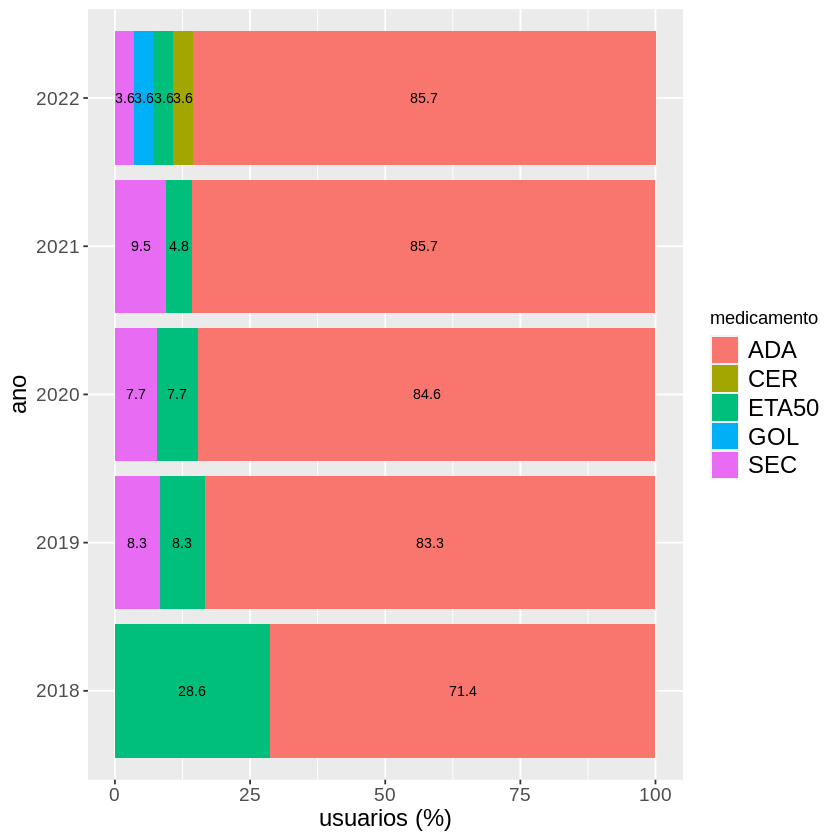

In [93]:
if(!require(ggplot2)) {install.packages("ggplot2"); require(ggplot2)} # funcao getURL


ggplot(
  paam_anual_valor,
  aes(
    fill = medicamento,
    y = usuario_perc,
    x = ano,
    label = usuario_perc
  )
) + geom_bar(stat = "identity") +
  xlab('ano') +
  ylab('usuarios (%)') +
  geom_text(size = 3, position = position_stack(vjust = 0.5)) +
  coord_flip() +
  theme(
    legend.text = element_text(size = rel(1.3)),
    axis.title.x = element_text(size = rel(1.3)),
    axis.title.y = element_text(size = rel(1.3)),
    axis.text.x = element_text(size = rel(1.3)),
    axis.text.y = element_text(size = rel(1.3))
  )

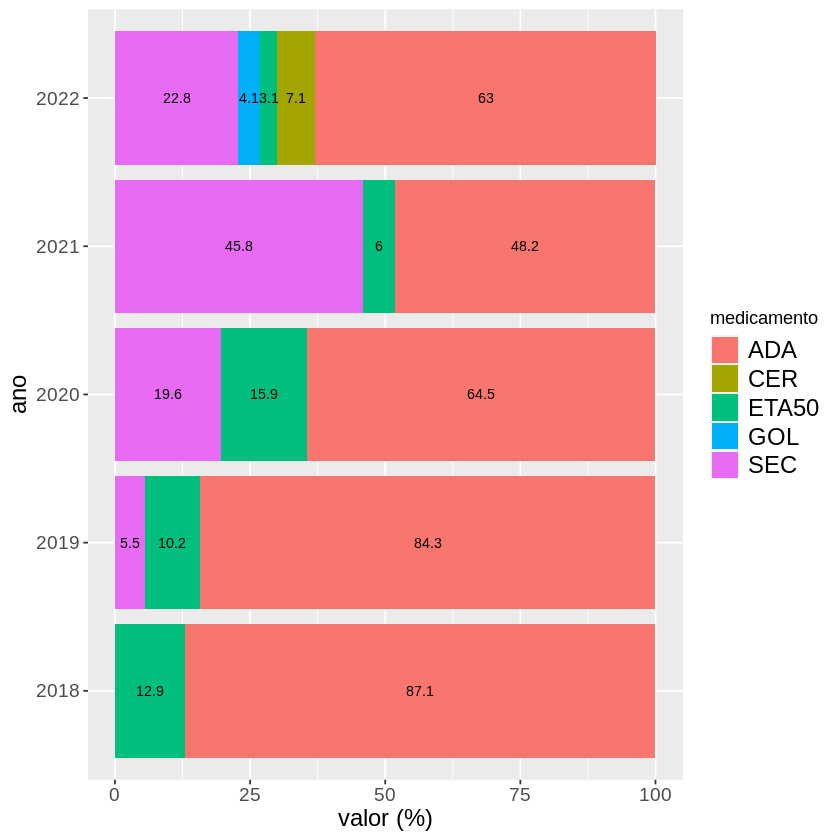

In [94]:
ggplot(
  paam_anual_valor,
  aes(
    fill = medicamento,
    y = total_perc,
    x = ano,
    label = total_perc
  )
) + geom_bar(stat = "identity") +
  xlab('ano') +
  ylab('valor (%)') +
  geom_text(size = 3, position = position_stack(vjust = 0.5)) +
  coord_flip() +
  theme(
    legend.text = element_text(size = rel(1.3)),
    axis.title.x = element_text(size = rel(1.3)),
    axis.title.y = element_text(size = rel(1.3)),
    axis.text.x = element_text(size = rel(1.3)),
    axis.text.y = element_text(size = rel(1.3))
  )

In [121]:
 paam_mensal_valor = merge(
        paam_atendimento, valor, 
        by.x=c("ano","medicamento"), 
        by.y=c("ano","medicamento"), 
        all.x = TRUE
      )
# produto entre total aprovado e valor unitario
paam_mensal_valor$total=round(paam_mensal_valor$PA_QTDAPR*paam_mensal_valor$unidade)
    
    total=aggregate(
  total ~ PA_CMP + medicamento, 
  data = subset(
      paam_mensal_valor,
      medicamento == 'ADA' 
    ), 
  FUN = sum, 
  na.rm = TRUE
)
head(total,20)

,PA_CMP,medicamento,total
,<dbl>,<chr>,<dbl>
1,201801,ADA,911700
2,201802,ADA,298835
3,201803,ADA,587540
4,201804,ADA,1154820
5,201805,ADA,835725
6,201806,ADA,557150
7,201807,ADA,820530
8,201808,ADA,536890
9,201809,ADA,790140


## Projeção com ARIMA

Os dados de mundo real obtidos podem ser processados com técnicas de regressão ou séries temporais.

Vamos ilustrar com o método ARIMA.

,previsão,min80,min95,max80,max95
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
61,29811.22,-297012.4,356634.8,-470022.4,529644.8
62,29811.22,-312242.4,371864.9,-493314.7,552937.2
63,29811.22,-326822.7,386445.1,-515613.3,575235.7
64,29811.22,-340829.8,400452.3,-537035.3,596657.8
65,29811.22,-354326.5,413949.0,-557676.8,617299.2
66,29811.22,-367364.9,426987.3,-577617.2,637239.6
67,29811.22,-379988.6,439611.0,-596923.5,656545.9
68,29811.22,-392234.9,451857.3,-615652.6,675275.0
69,29811.22,-404135.7,463758.2,-633853.3,693475.8


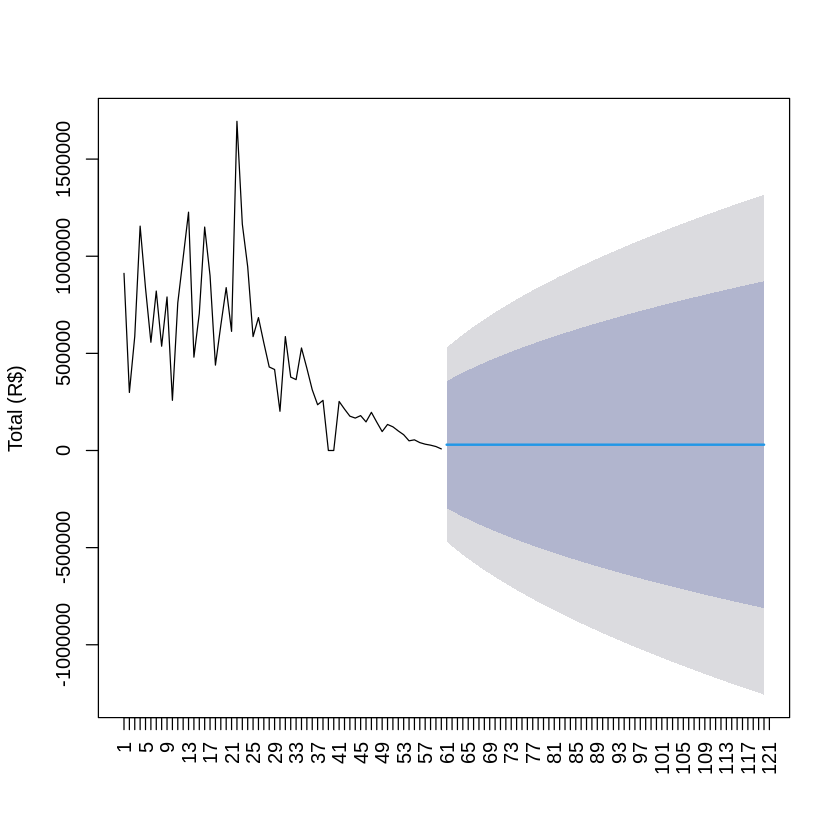

In [122]:
if(!require(forecast)) {install.packages("forecast"); require(forecast)} # funcao getURL
if(!require(tseries)) {install.packages("tseries"); require(tseries)} # funcao getURL

arima_data=forecast(auto.arima(
    total$total,
    allowmean = TRUE
  ), h = 60)

plot(
  arima_data,
  xlab = "",
  ylab = "Total (R$)",
  main = "",
  las = 3  ,
  xaxt = 'n'
)

axis(1,
     at = 1:(nrow(total)+61),
     labels = 1:(nrow(total)+61),
     las = 3)

arima_data=as.data.frame(arima_data)
colnames(arima_data)=c("previsão","min80","min95","max80","max95")
tail(arima_data,60)

,PA_CMP,medicamento,AP_CNSPCN
,<dbl>,<chr>,<int>
41,202105,ADA,9
42,202106,ADA,9
43,202107,ADA,12
44,202108,ADA,8
45,202109,ADA,9
46,202110,ADA,7
47,202111,ADA,10
48,202112,ADA,11
49,202201,ADA,11


,previsão,min80,min95,max80,max95
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
61,10.68896,8.542094,12.83583,7.405610,13.97232
62,10.82371,8.579313,13.06811,7.391200,14.25623
63,10.95846,8.620599,13.29633,7.383007,14.53392
64,11.09322,8.665479,13.52095,7.380314,14.80612
65,11.22797,8.713570,13.74236,7.382529,15.07340
66,11.36272,8.764550,13.96088,7.389163,15.33627
67,11.49747,8.818148,14.17679,7.399801,15.59513
68,11.63222,8.874132,14.39031,7.414089,15.85035
69,11.76697,8.932304,14.60164,7.431723,16.10222


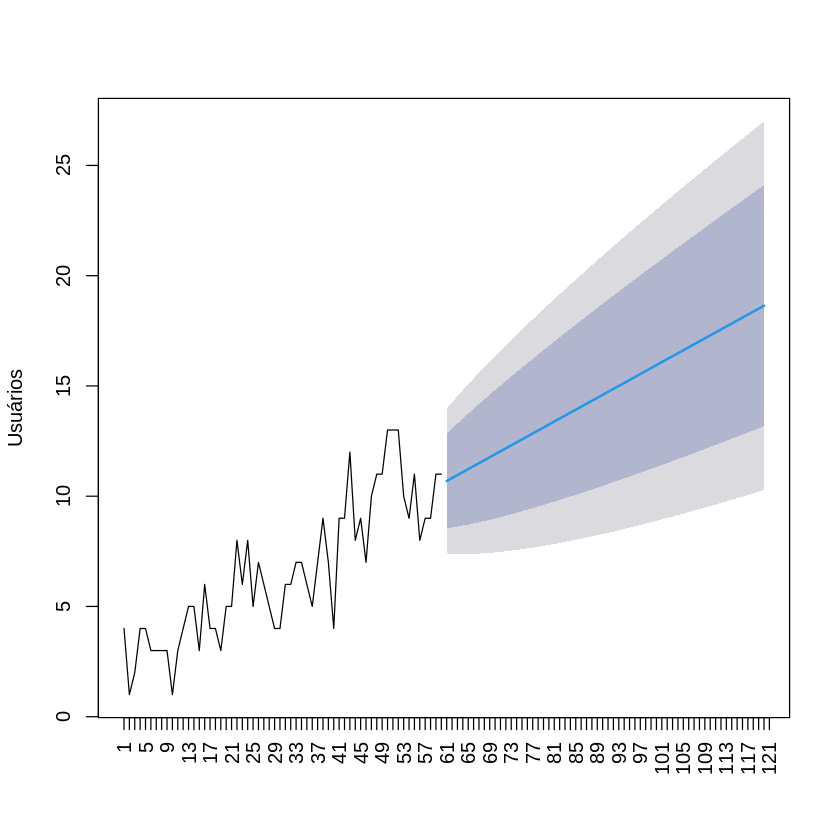

In [126]:
usuarios=aggregate(
  AP_CNSPCN ~ PA_CMP + medicamento, 
  data = subset(
      paam_atendimento,
      medicamento == 'ADA' 
    ),
  function(x) length(unique(x))
)
tail(usuarios,20)

arima_data=forecast(auto.arima(
    usuarios$AP_CNSPCN,
    allowmean = TRUE
  ), h = 60)

plot(
  arima_data,
  xlab = "",
  ylab = "Usuários",
  main = "",
  las = 3  ,
  xaxt = 'n'
)

axis(1,
     at = 1:(nrow(total)+61),
     labels = 1:(nrow(total)+61),
     las = 3)

arima_data=as.data.frame(arima_data)
colnames(arima_data)=c("previsão","min80","min95","max80","max95")
tail(arima_data,60)